# Build Image

In this notebook, we show the following steps for deploying a web service using AML:

- Create an image
- Test image locally


In [1]:
%matplotlib inline

import docker
import matplotlib.pyplot as plt
import numpy as np
import requests
from azureml.core import Workspace
from azure.mgmt.containerregistry import ContainerRegistryManagementClient
from azureml._model_management._util import (get_docker_client, pull_docker_image)
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.image import ContainerImage
from dotenv import set_key, get_key, find_dotenv
from utilities import load_image_into_numpy_array
from PIL import Image

import sys
import os
import json
sys.path.append("../models/research/")
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from matplotlib import pyplot as plt

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [3]:
image_name = 'maskrcnnoutofstockimage' # You can pick another image name here
model_name = get_key(env_path,"model_name")
resource_group = get_key(env_path, 'resource_group')

In [4]:
set_key(env_path, "image_name", image_name)

(True, 'image_name', 'maskrcnnoutofstockimage')

## Get workspace
Load existing workspace from the config file info.

In [6]:
ws = Workspace.from_config()
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /datadrive/OutOfStockDemo/.azureml/config.json


## Create Image

In [6]:
# create yml file to be used in the image
conda_pack = ["tensorflow==1.12.0"]
requirements = ["Pillow==6.0.0", "azureml-defaults==1.0.23"]

imgenv = CondaDependencies.create(conda_packages=conda_pack,pip_packages=requirements)
with open("img_env.yml", "w") as f:
    f.write(imgenv.serialize_to_string())

In [7]:
image_config = ContainerImage.image_configuration(execution_script = "detect.py",
                                                  runtime = "python",
                                                  conda_file = "img_env.yml",
                                                  description = "MaskRCNN image for out of stock model",
                                                  tags = {"data":"products","method":"tensorflow"}
                                               )

In [8]:
# create image. It may take upto 15-20 minutes. 
image = ContainerImage.create(name = image_name,
                              # this is the model object
                              models = [ws.models[model_name]],                              
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running..................................................................
SucceededImage creation operation finished for image maskrcnnoutofstockimage:1, operation "Succeeded"


In [10]:
# You can find the logs of image creation
# image.image_build_log_uri

# You can get the image object when not creating a new image
# image = ws.images[image_name]

## Test image locally
- Pull the image from ACR registry to local host 
- Start a container
- Test API call

In [11]:
# Getting your container details
container_reg = ws.get_details()["containerRegistry"]
reg_name=container_reg.split("/")[-1]
container_url = "\"" + image.image_location + "\","
subscription_id = ws.subscription_id

client = ContainerRegistryManagementClient(ws._auth,subscription_id)
result= client.registries.list_credentials(resource_group, reg_name, custom_headers=None, raw=False)
username = result.username
password = result.passwords[0].value
print('ContainerURL:{}'.format(image.image_location))
print('Servername: {}'.format(reg_name))
print('Username: {}'.format(username))
print('Password: {}'.format(password))

ContainerURL:fboyluamlsdkws7798851753.azurecr.io/maskrcnnoutofstockimage:1
Servername: fboyluamlsdkws7798851753
Username: fboyluamlsdkws7798851753
Password: Aorh+fqjzGK5Y0zO3pzf5IDd6iyAxcBe


In [10]:
dc = get_docker_client()

In [11]:
pull_docker_image(dc, image.image_location, username, password)

Pulling image from ACR (this may take a few minutes depending on image size)...

{"status":"Pulling from maskrcnnoutofstockimage","id":"1"}
{"status":"Already exists","progressDetail":{},"id":"34667c7e4631"}
{"status":"Already exists","progressDetail":{},"id":"d18d76a881a4"}
{"status":"Already exists","progressDetail":{},"id":"119c7358fbfc"}
{"status":"Already exists","progressDetail":{},"id":"2aaf13f3eff0"}
{"status":"Already exists","progressDetail":{},"id":"90cd7c0aa2c0"}
{"status":"Already exists","progressDetail":{},"id":"4594288b8cf8"}
{"status":"Already exists","progressDetail":{},"id":"de6ac616097c"}
{"status":"Already exists","progressDetail":{},"id":"ead138b89e0a"}
{"status":"Already exists","progressDetail":{},"id":"7c294f6a1d26"}
{"status":"Already exists","progressDetail":{},"id":"e7fdcf967ed3"}
{"status":"Already exists","progressDetail":{},"id":"0e9b35f2cb13"}
{"status":"Already exists","progressDetail":{},"id":"e2b7b5e752ff"}
{"status":"Already exists","progressDetail":

{"status":"Downloading","progressDetail":{"current":4308992,"total":435458173},"progress":"[\u003e                                                  ]  4.309MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":4685824,"total":16977275},"progress":"[=============\u003e                                     ]  4.686MB/16.98MB","id":"1fd1a94dc70b"}
{"status":"Extracting","progressDetail":{"current":8355840,"total":47975234},"progress":"[========\u003e                                          ]  8.356MB/47.98MB","id":"493f12a59564"}
{"status":"Downloading","progressDetail":{"current":8634368,"total":435458173},"progress":"[\u003e                                                  ]  8.634MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":8470528,"total":16977275},"progress":"[========================\u003e                          ]  8.471MB/16.98MB","id":"1fd1a94dc70b"}
{"status":"Extracting","progressDetail":{"current":12288000

{"status":"Downloading","progressDetail":{"current":52969472,"total":435458173},"progress":"[======\u003e                                            ]  52.97MB/435.5MB","id":"41372b9e4cde"}
{"status":"Pull complete","progressDetail":{},"id":"7d163e008bd8"}
{"status":"Extracting","progressDetail":{"current":492,"total":492},"progress":"[==================================================\u003e]     492B/492B","id":"a4771f537262"}
{"status":"Extracting","progressDetail":{"current":492,"total":492},"progress":"[==================================================\u003e]     492B/492B","id":"a4771f537262"}
{"status":"Downloading","progressDetail":{"current":54591488,"total":435458173},"progress":"[======\u003e                                            ]  54.59MB/435.5MB","id":"41372b9e4cde"}
{"status":"Pull complete","progressDetail":{},"id":"a4771f537262"}
{"status":"Downloading","progressDetail":{"current":56754176,"total":435458173},"progress":"[======\u003e                               

{"status":"Downloading","progressDetail":{"current":116768768,"total":435458173},"progress":"[=============\u003e                                     ]  116.8MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":118390784,"total":435458173},"progress":"[=============\u003e                                     ]  118.4MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":120553472,"total":435458173},"progress":"[=============\u003e                                     ]  120.6MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":122175488,"total":435458173},"progress":"[==============\u003e                                    ]  122.2MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":124878848,"total":435458173},"progress":"[==============\u003e                                    ]  124.9MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"cu

{"status":"Downloading","progressDetail":{"current":208683008,"total":435458173},"progress":"[=======================\u003e                           ]  208.7MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":209764352,"total":435458173},"progress":"[========================\u003e                          ]  209.8MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":211927040,"total":435458173},"progress":"[========================\u003e                          ]  211.9MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":213549056,"total":435458173},"progress":"[========================\u003e                          ]  213.5MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":215171072,"total":435458173},"progress":"[========================\u003e                          ]  215.2MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"cu

{"status":"Downloading","progressDetail":{"current":291946496,"total":435458173},"progress":"[=================================\u003e                 ]  291.9MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":294109184,"total":435458173},"progress":"[=================================\u003e                 ]  294.1MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":295731200,"total":435458173},"progress":"[=================================\u003e                 ]  295.7MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":297893888,"total":435458173},"progress":"[==================================\u003e                ]  297.9MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":300056576,"total":435458173},"progress":"[==================================\u003e                ]  300.1MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"cu

{"status":"Downloading","progressDetail":{"current":380616704,"total":435458173},"progress":"[===========================================\u003e       ]  380.6MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":381698048,"total":435458173},"progress":"[===========================================\u003e       ]  381.7MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":384401408,"total":435458173},"progress":"[============================================\u003e      ]  384.4MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":386023424,"total":435458173},"progress":"[============================================\u003e      ]    386MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"current":388726784,"total":435458173},"progress":"[============================================\u003e      ]  388.7MB/435.5MB","id":"41372b9e4cde"}
{"status":"Downloading","progressDetail":{"cu

{"status":"Extracting","progressDetail":{"current":32309248,"total":435458173},"progress":"[===\u003e                                               ]  32.31MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":35094528,"total":435458173},"progress":"[====\u003e                                              ]  35.09MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":37879808,"total":435458173},"progress":"[====\u003e                                              ]  37.88MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":40665088,"total":435458173},"progress":"[====\u003e                                              ]  40.67MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":43450368,"total":435458173},"progress":"[====\u003e                                              ]  43.45MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":4623

{"status":"Extracting","progressDetail":{"current":149291008,"total":435458173},"progress":"[=================\u003e                                 ]  149.3MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":151519232,"total":435458173},"progress":"[=================\u003e                                 ]  151.5MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":154304512,"total":435458173},"progress":"[=================\u003e                                 ]  154.3MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":156532736,"total":435458173},"progress":"[=================\u003e                                 ]  156.5MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":159318016,"total":435458173},"progress":"[==================\u003e                                ]  159.3MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current"

{"status":"Extracting","progressDetail":{"current":269058048,"total":435458173},"progress":"[==============================\u003e                    ]  269.1MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":271843328,"total":435458173},"progress":"[===============================\u003e                   ]  271.8MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":274628608,"total":435458173},"progress":"[===============================\u003e                   ]  274.6MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":277413888,"total":435458173},"progress":"[===============================\u003e                   ]  277.4MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":279642112,"total":435458173},"progress":"[================================\u003e                  ]  279.6MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current"

{"status":"Extracting","progressDetail":{"current":369885184,"total":435458173},"progress":"[==========================================\u003e        ]  369.9MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":372113408,"total":435458173},"progress":"[==========================================\u003e        ]  372.1MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":374341632,"total":435458173},"progress":"[==========================================\u003e        ]  374.3MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":376012800,"total":435458173},"progress":"[===========================================\u003e       ]    376MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current":377683968,"total":435458173},"progress":"[===========================================\u003e       ]  377.7MB/435.5MB","id":"41372b9e4cde"}
{"status":"Extracting","progressDetail":{"current"

In [12]:
# make sure port 80 is not occupied
container_labels = {'containerName': 'tfgpu'}
container = dc.containers.run(image.image_location, 
                                         detach=True, 
                                         ports={'5001/tcp': 80},
                                         labels=container_labels,
                                         runtime='nvidia' )

In [14]:
# for log_msg in container.logs(stream=True):
#     str_msg = log_msg.decode('UTF8')
#     print(str_msg)

In [15]:
client = docker.APIClient()
details = client.inspect_container(container.id)

In [16]:
service_ip = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostIp']
service_port = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostPort']

Wait a few seconds for the application to spin up and then check that everything works.

In [17]:
print('Checking service on {} port {}'.format(service_ip, service_port))

Checking service on 0.0.0.0 port 80


In [18]:
endpoint="http://__service_ip:__service_port"
endpoint = endpoint.replace('__service_ip', service_ip)
endpoint = endpoint.replace('__service_port', service_port)

In [28]:
!curl 'http://{service_ip}:{service_port}/'

Healthy

In [29]:
img_data = open('./annotated/runeightft3/1555539843.1911.jpg', "rb")

In [30]:
%time r = requests.post('http://0.0.0.0:80/score', files={'image': img_data})

CPU times: user 5.28 ms, sys: 365 µs, total: 5.64 ms
Wall time: 4.76 s


In [31]:
print(r)
r.json()

<Response [200]>


'{"num_detections": 104, "detection_boxes": [[0.3391762971878052, 0.3063299357891083, 0.5386672616004944, 0.41031599044799805], [0.32618868350982666, 0.5964620113372803, 0.5296524167060852, 0.6811696887016296], [0.559687077999115, 0.663791298866272, 0.7023747563362122, 0.7327619194984436], [0.5601957440376282, 0.40963414311408997, 0.7010723948478699, 0.45945414900779724], [0.8473771214485168, 0.5836719870567322, 0.9254916310310364, 0.6539986729621887], [0.05849780887365341, 0.5102877020835876, 0.29122599959373474, 0.6312167048454285], [0.5563908815383911, 0.5567432641983032, 0.69914710521698, 0.6137965321540833], [0.7283585071563721, 0.6964464783668518, 0.8229084014892578, 0.7432740330696106], [0.5752831697463989, 0.7800224423408508, 0.7069563269615173, 0.8291115760803223], [0.8507676720619202, 0.4011346697807312, 0.9268958568572998, 0.44280803203582764], [0.7314102053642273, 0.3150431513786316, 0.8270384073257446, 0.3517536222934723], [0.7265341281890869, 0.5060259103775024, 0.8255383

In [35]:
PATH_TO_LABELS = 'stockout_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

IMAGE_SIZE = (24, 18)

In [37]:
img = Image.open(img_data)
image_np = load_image_into_numpy_array(img)
output_dict = json.loads(r.json())

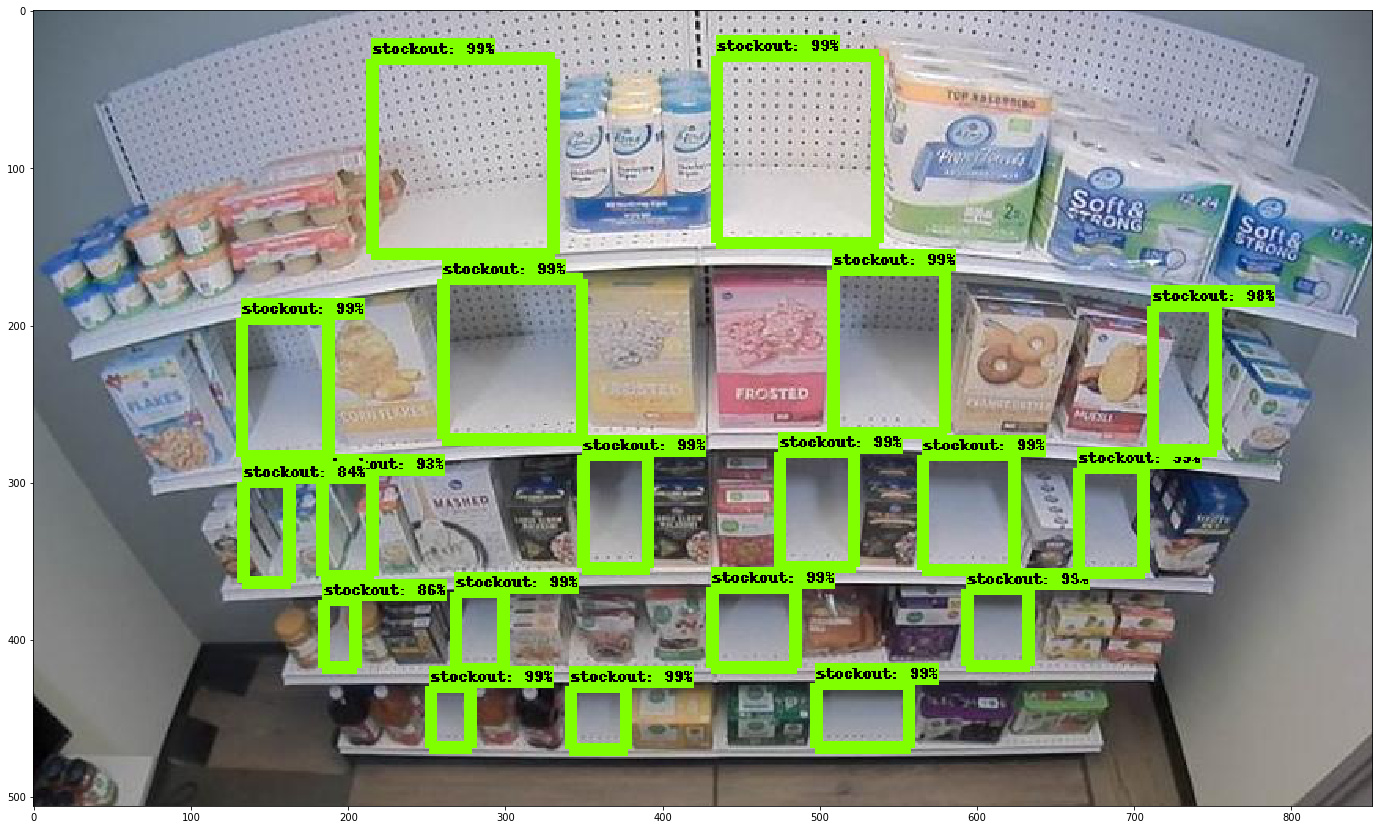

In [38]:
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  np.array(output_dict['detection_boxes']),
  np.array(output_dict['detection_classes']),
  np.array(output_dict['detection_scores']),
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [39]:
container.stop()

In [40]:
# remove stopped container
!docker system prune -f

Deleted Containers:
aac71bafd091b75679ce770b9a42e02ffabe0702ad50860a80b56551f9a4b0c5

Total reclaimed space: 24.72MB
